In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np

In [2]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2021-12-15 10:45:54--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.186.144, 142.250.185.176, 142.250.186.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.186.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91,38K  --.-KB/s    in 0,05s   

2021-12-15 10:45:55 (1,68 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [3]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

2021-12-15 10:45:55.902288: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [4]:
history = model.fit(predictors, label, epochs=100, verbose=1)

2021-12-15 10:45:57.366188: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
484/484 [==============================] - 39s 69ms/step - loss: 6.9116 - accuracy: 0.0242
Epoch 2/100
484/484 [==============================] - 46s 96ms/step - loss: 6.5018 - accuracy: 0.0217
Epoch 3/100
484/484 [==============================] - 45s 92ms/step - loss: 6.3987 - accuracy: 0.0240
Epoch 4/100
484/484 [==============================] - 40s 84ms/step - loss: 6.2724 - accuracy: 0.0294
Epoch 5/100
484/484 [==============================] - 42s 87ms/step - loss: 6.1773 - accuracy: 0.0362
Epoch 6/100
484/484 [==============================] - 44s 90ms/step - loss: 6.0967 - accuracy: 0.0375
Epoch 7/100
484/484 [==============================] - 44s 92ms/step - loss: 6.0201 - accuracy: 0.0408
Epoch 8/100
484/484 [==============================] - 45s 93ms/step - loss: 5.9409 - accuracy: 0.0456
Epoch 9/100
484/484 [==============================] - 43s 89ms/step - loss: 5.8384 - accuracy: 0.0521
Epoch 10/100
484/484 [==============================] - 43s 89ms/step - l

484/484 [==============================] - 38s 79ms/step - loss: 1.3969 - accuracy: 0.7607
Epoch 80/100
484/484 [==============================] - 39s 80ms/step - loss: 1.3893 - accuracy: 0.7624
Epoch 81/100
484/484 [==============================] - 41s 84ms/step - loss: 1.3666 - accuracy: 0.7648
Epoch 82/100
484/484 [==============================] - 38s 79ms/step - loss: 1.3422 - accuracy: 0.7712
Epoch 83/100
484/484 [==============================] - 40s 83ms/step - loss: 1.3289 - accuracy: 0.7739
Epoch 84/100
484/484 [==============================] - 41s 84ms/step - loss: 1.3198 - accuracy: 0.7729
Epoch 85/100
484/484 [==============================] - 40s 83ms/step - loss: 1.3089 - accuracy: 0.7763
Epoch 86/100
484/484 [==============================] - 40s 82ms/step - loss: 1.2905 - accuracy: 0.7803
Epoch 87/100
484/484 [==============================] - 40s 83ms/step - loss: 1.2788 - accuracy: 0.7826
Epoch 88/100
484/484 [==============================] - 41s 85ms/step - loss:

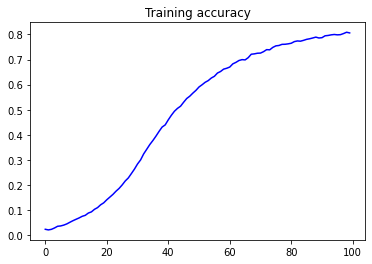

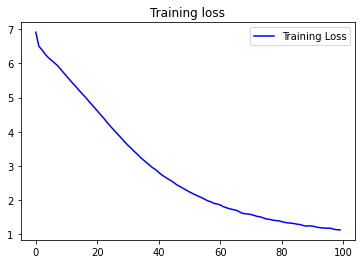

In [7]:
import matplotlib.pyplot as plt
acc =  history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [8]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predict_output = model.predict(token_list)
    predicted = np.argmax(predict_output, axis=1) #model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope must you be dumb 'will ' hate lies doth keep another way place ' lies 'will ' doth keep doth come tear free express'd grow of groan doth endure behold shade hate of room hate ' ' releasing dyed shine bright life again doth grow mad seen seen speak doth remain live decay despair you room bright go up room latch chary chary chary free speak away her wit green it live thy eye doth pry groan away away thine eyes must you have i have not know she doth foes near care is eyes must live be free of
